In [16]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import poisson
import pytensor.tensor as pt

plt.rcParams['font.family'] ='AppleGothic'
plt.rcParams['axes.unicode_minus'] =False

In [2]:
final_data = pd.read_pickle('./data/final_data.pkl')
train_data = pd.read_pickle('./data/train_data.pkl')
approx_sample = pd.read_pickle('./results/sampling_results.pkl')

#### 추정된 Parameter 값 가져오기

In [3]:
alpha = {}
alpha[1] = approx_sample.posterior.alpha_1.values.mean(axis=1)
alpha[2] = approx_sample.posterior.alpha_2.values.mean(axis=1)
alpha[3] = approx_sample.posterior.alpha_3.values.mean(axis=1)
alpha[4] = approx_sample.posterior.alpha_4.values.mean(axis=1)
alpha[5] = approx_sample.posterior.alpha_5.values.mean(axis=1)
alpha[6] = approx_sample.posterior.alpha_6.values.mean(axis=1)
alpha[7] = approx_sample.posterior.alpha_7.values.mean(axis=1)
alpha[8] = approx_sample.posterior.alpha_8.values.mean(axis=1)
alpha[9] = approx_sample.posterior.alpha_9.values.mean(axis=1)
alpha[10] = approx_sample.posterior.alpha_10.values.mean(axis=1)
alpha[11] = approx_sample.posterior.alpha_11.values.mean(axis=1)
alpha[12] = approx_sample.posterior.alpha_12.values.mean(axis=1)
alpha[13] = approx_sample.posterior.alpha_13.values.mean(axis=1)
alpha[14] = approx_sample.posterior.alpha_14.values.mean(axis=1)
alpha[15] = approx_sample.posterior.alpha_15.values.mean(axis=1)
alpha[16] = approx_sample.posterior.alpha_16.values.mean(axis=1)
alpha[17] = approx_sample.posterior.alpha_17.values.mean(axis=1)
alpha[18] = approx_sample.posterior.alpha_18.values.mean(axis=1)
alpha[19] = approx_sample.posterior.alpha_19.values.mean(axis=1)
beta = approx_sample.posterior.beta.values.mean()
hw = approx_sample.posterior.home_ad.values.mean()

In [4]:
#parameters = {'alpha':alpha, 'beta':beta, 'hw':hw}
#with open('./model/parameters.pkl', 'wb') as f:    
#    pickle.dump(parameters, f)

#### 경기 예측 모형 만들기

In [5]:
def predict(home_X, away_X, frame=1):
    h_lambda = np.exp((home_X * alpha[frame]).sum() + beta + hw)
    a_lambda = np.exp((away_X * alpha[frame]).sum() + beta)
    
    h_goal = home_X[2]
    a_goal = away_X[2]

    h_poisson = poisson((1-(frame/20))*h_lambda)
    a_poisson = poisson((1-(frame/20))*a_lambda)

    results = h_poisson.rvs(1000) - a_poisson.rvs(1000) + h_goal - a_goal
    win_p = ((results>0).sum()/1000, (results==0).sum()/1000, (results<0).sum()/1000)

    return win_p

#### 평가지표 RPS(Rank Probability Score)

In [6]:
def rps(output, y):
    output = np.array(output)
    y = np.array(y)
    rps = 0
    for i in range(len(y)):
        rps += (y[:i+1].sum() - output[:i+1].sum())**2
    return rps/(len(y)-1)

In [7]:
def home_win(score):
    if score > 0 :
        return (1, 0, 0)
    elif score == 0 :
        return (0, 1, 0)
    else : 
        return (0, 0, 1)

In [8]:
y_true = [home_win(final_data[i][0]['home_score'] - final_data[i][0]['away_score']) for i in final_data.keys()]

In [9]:
train_data['X']['home'].shape

(20, 814, 9)

In [10]:
rps_list = []
for frame in np.arange(1, 20):
    t_rps = 0
    for i in range(len(y_true)):
        t_pred = predict(home_X= train_data['X']['home'][frame-1,i,:], away_X= train_data['X']['away'][frame-1,i,:], frame=frame)
        t_y = y_true[i]
        t_rps += rps(t_pred, t_y)
    t_rps /= len(y_true)
    rps_list.append(t_rps)

#### 예측 시점 별 RPS 값

''

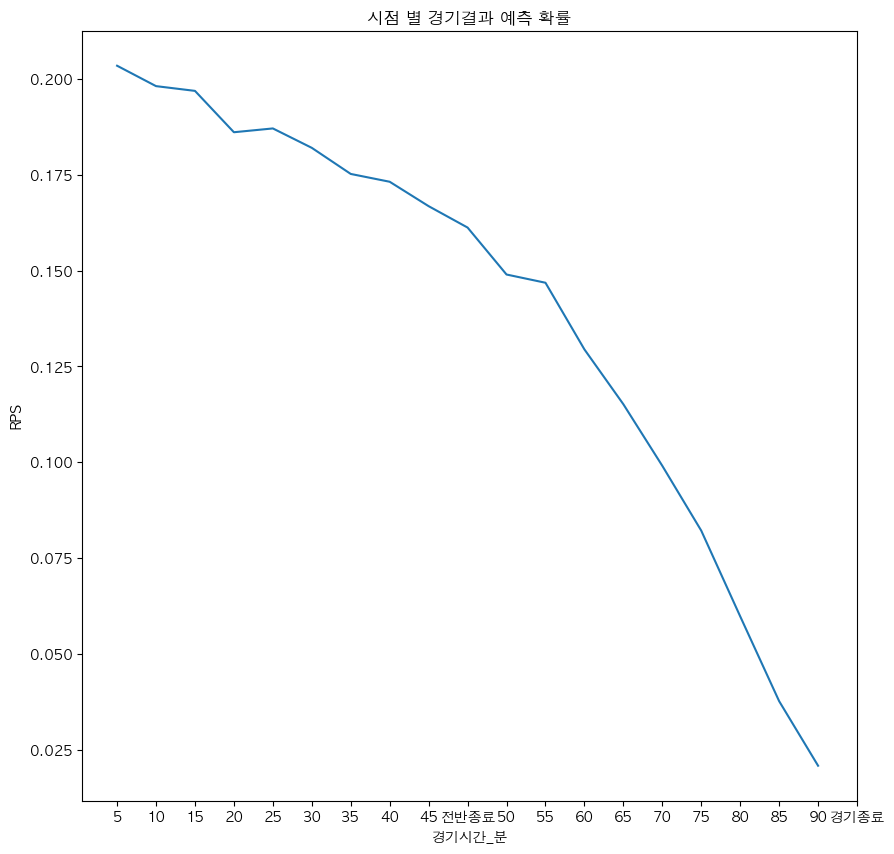

In [21]:
plt.figure(figsize=(10, 10))
plt.plot(rps_list)
plt.title("시점 별 경기결과 예측 확률")
plt.xticks(np.arange(0,20), [5, 10, 15, 20, 25, 30, 35, 40, 45, '전반종료',
                             50, 55, 60, 65, 70, 75, 80, 85, 90, '경기종료'])
plt.ylabel('RPS')
plt.xlabel('경기시간(분)')
;